# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import os
import pickle
import matplotlib.pyplot as plt
import csv
import random
import skimage.data
import skimage.transform
import matplotlib
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import train_test_split
import time
import math
from tqdm import tqdm
import cv2
import random
import matplotlib.gridspec as gridspec


plt.rcParams['figure.figsize']=(8,8)
plt.rcParams['image.interpolation']='nearest'
np.set_printoptions(suppress=True)


# Allow image embeding in notebook
%matplotlib inline


# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### To start off let's do a basic data summary.
# TODO: number of training examples
n_train = len(y_train)

# TODO: number of testing examples
n_test = len(y_test)

# TODO: what's the shape of an image?
image_size=X_train.shape

image_shape = (image_size[1], image_size[2],image_size[3])

# # TODO: how many classes are in the dataset
n_classes = len(set(y_test))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
csv_file='signnames.csv'

#get sign names from csv file and then create an array to store
def get_labels(csv_path):

# from each row in the file.
    labels = []
    with open(csv_path, 'r') as fp:
        dir_csv = csv.reader(fp, delimiter=';')
        next(dir_csv)
        for row in dir_csv:
            for i in row:
                labels.append(i[2:])
    return labels
                          
sign_label=get_labels(csv_file)
sign_names=np.array(sign_label)




### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

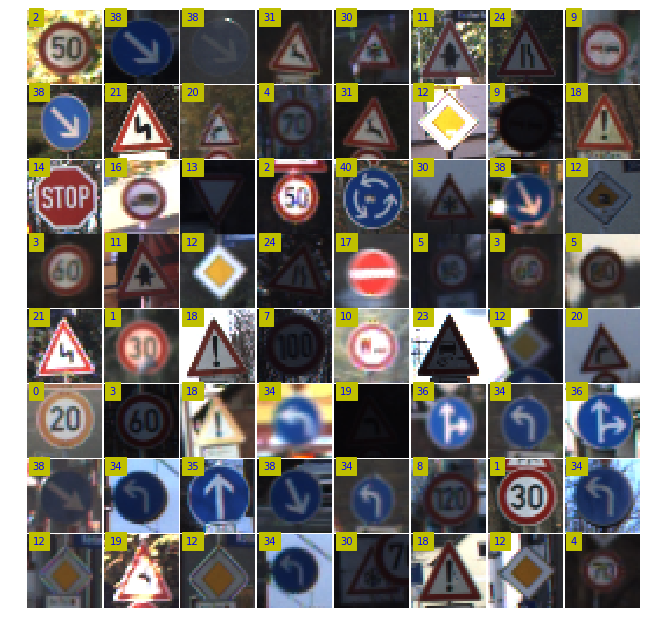

In [4]:
def plot_random_data(row,col,x,y):

    
    plt.figure(  figsize=(11,11))
    grid=gridspec.GridSpec(row,col)
    grid.update(wspace=0.01, hspace=0.01)
    
    for i in range(row * col):
        ax1=plt.subplot(grid[i])
        plt.axis('on')
        ax1.set_aspect('equal')
        index=np.random.randint(len(y))
        plt.imshow(x[index])
        plt.text(2,4,str(y[index]), color='b', backgroundcolor='y')
        plt.axis('off')
    plt.show()
    
plot_random_data(8,8,X_train, y_train)   

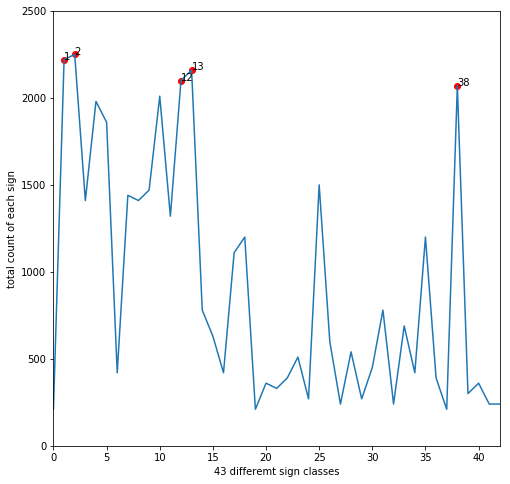

In [5]:
##plotted a diagram of showing total count of each sign 

plt.figure(figsize=(8,8))
   
train_total=[]
for label in range(n_classes):
    count=len(y_train[y_train==label])
    train_total.append(count)
    

train_sort=np.sort(train_total)[::-1][:5]
index=np.argsort(train_total)[::-1][:5]


for k in range(5):
    plt.plot(index[k],train_sort[k],'ro' )
    plt.annotate(index[k], xy=(index[k],train_sort[k]))
    plt.axis([0,42,-0.5,2])
    
plt.plot(train_total)
plt.xlabel("43 differemt sign classes")
plt.ylabel("total count of each sign")
plt.axis([0, 42, 0, 2500])
plt.show()



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

##### Preprocess the data here.
### Feel free to use as many code cells as needed.


In [6]:
##Augmenting training dataset

(-0.5, 31.5, 31.5, -0.5)

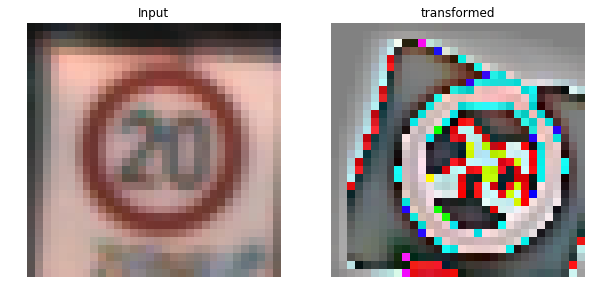

In [7]:
def preprocess_image(img):
    img[:,:,0]=cv2.equalizeHist(img[:,:,0])
    img[:,:,1]=cv2.equalizeHist(img[:,:,1])
    img[:,:,2]=cv2.equalizeHist(img[:,:,2])
#     img=img/127.5 -1.
    img=img/255 -.5
    return img

def brightness_augmentation(img):
    img=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    random_bright=.5 +np.random.uniform()
    img[:,:,1]=img[:,:,1]*random_bright
    img=cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

def affine_transform(img,rot_range,trans_range, shear_range):
    """
    Applies affine transfrom to the image to get a
    distorted image that is different from the original one.
    """
    #rotation
    rot=np.random.uniform(rot_range)-rot_range/2 ##-0.5-0.5
    rows,cols,ch=img.shape
    Rot_M=cv2.getRotationMatrix2D((cols/2, rows/2), rot,1)
    
    #transformation
    trans_x=trans_range*np.random.uniform(trans_range) - trans_range/2
    trans_y=trans_range*np.random.uniform(trans_range) - trans_range/2
    Trans_M=np.float32([[1,0,trans_x],[0,1,trans_y]])
    
    # Shear
    pt1=5+shear_range*np.random.uniform()-shear_range/2
    pt2=20+shear_range*np.random.uniform()-shear_range/2
    
    pts1=np.float32([[5,5],[20,5],[5,20]])
    pts2=np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    Shear_M=cv2.getAffineTransform(pts1,pts2)
    
    img=cv2.warpAffine(img, Rot_M,   (cols,rows))
    img=cv2.warpAffine(img, Trans_M, (cols,rows))
    img=cv2.warpAffine(img, Shear_M, (cols,rows))
      
    img=preprocess_image(img)
#     img=brightness_augmentation(img)
    return img

plt.figure(figsize=(10,10))

img = X_train[100]
trans_img=affine_transform(img,40,2,2)

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Input')
plt.axis('off')
plt.subplot(122)
plt.imshow(trans_img, cmap='gray')
plt.title('transformed')
plt.axis('off')

In [8]:
train_features=[]
train_labels=[]
#iterate over each class and affine transform will be applied if some 
#classes have count of sample exmaples under 500
process_bar = tqdm(range(n_classes), desc='Progress', unit='class')
total_count = 1200

for cls in process_bar:
    for count in range(total_count):
        rand=random.randint(0,train_total[cls]-1)
        dst=affine_transform(X_train[np.argwhere(y_train==cls)[rand]][0],35,2,2)
        train_features.append(dst)
        train_labels.append(cls)
print("Number of training examples =", len(train_features))

Progress: 100%|██████████| 43/43 [00:13<00:00,  3.33class/s]

Number of training examples = 51600


In [9]:
train_features=np.array(train_features)
train_labels=np.array(train_labels)
print(train_features.shape)
train_labels.shape

(51600, 32, 32, 3)


(51600,)

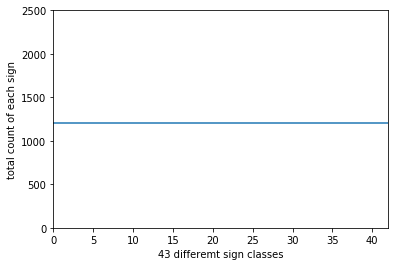

In [10]:
# Count the classes from the feature set after transformation

train_total2=[]
for label in range(n_classes):
    count=len(train_labels[train_labels==label])
    train_total2.append(count)
plt.plot(train_total2)
plt.xlabel("43 differemt sign classes")
plt.ylabel("total count of each sign")
plt.axis([0, 42, 0, 2500])
plt.show()

In [11]:
#show first 5 images which are in range between 0.1 and 0.9
for image in train_features[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))
train_labels.shape

shape: (32, 32, 3), min: -0.5, max: 0.5
shape: (32, 32, 3), min: -0.5, max: 0.5
shape: (32, 32, 3), min: -0.5, max: 0.5
shape: (32, 32, 3), min: -0.5, max: 0.5
shape: (32, 32, 3), min: -0.5, max: 0.5


(51600,)

In [12]:
#Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(train_labels)
train_labels = encoder.transform(train_labels)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
is_labels_encod = True
print('Labels One-Hot Encoded')

train_labels.shape

Labels One-Hot Encoded


(51600, 43)

In [13]:
# Get randomized datasets for training and validation
train_feature, valid_feature, train_label, valid_label = train_test_split(
    train_features,
    train_labels,
    test_size=0.2,
     random_state=80)
print(len(valid_label))
print(len(train_feature))

10320
41280


(12630, 32, 32, 3)
0.5


(12630, 43)

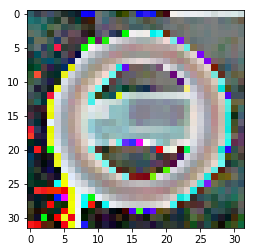

In [14]:
test_features= np.zeros(X_test.shape)
for i in range(len(X_test)):
    test_features[i]=preprocess_image(X_test[i])
    
print(test_features.shape)
print(test_features[0].max())
plt.imshow(test_features[0])
test_labels.shape

In [15]:
# # num=np.random.randint(43000)
# num=12523
# print(num)
# plt.imshow(train_features[num])
# train_labels[num]

**Answer:**
Since I found that each image features are wildly different and thus would cause some bad effects on learning, then I rescaled the image by dividing by 255 and subtracting 0.5 to make it in the range between -0.5 and 0.5. Now, all features are now weighted equally in this range.  Also I used label binarizing and one-hot encoding to convert each of categorical data to a vector and thus it is easy to do further computing, such as label prediction when with encoded labels matrix
Also I found that the unbalanced dataset probably is a reason of causing my training accuracy pretty low, because some classes have so poor performance. To solve this problem,  I used affine transformation function in order to augment the minimum amount of data points obtained in each class.

In [16]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
I applied train_test_split built-in helper function which randomly splits the original training data into training and validation. 


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


## **Answer:**
the first module is made by 3 1x1 filters. These filters have the effect of changing color maps.Since, we don't know which color map influenced the result the most,therefore by using 3 1x1 filters, I wanted to network itself end up choosing the best color map 
- the next 3 modules are comprised of 32, 64, 128 5x5 filters respectively, each was following by maxpooling and dropout. The output from each convolution layer was fed into a feedforward layer which was composed of 2 hidden layers(each layer contains 1024 nuerons).  Additional dropout layers are applied after each of the fully connected layers.


## Train your model here.
### Feel free to use as many code cells as needed.

In [17]:
#Convolutional layer0:
filter_size0=1
num_filters0=3

#Convolutional layer1:
filter_size1=5
num_filters1=32

#Convolutional layer2:
filter_size2=5
num_filters2=32

#Convolutional layer3:
filter_size3=5
num_filters3=64

#Convolutional layer4:
filter_size4=5
num_filters4=64

#Convolutional layer5:
filter_size5=5
num_filters5=128

#Convolutional layer6:
filter_size6=5
num_filters6=128

#Fully_connected 2-layers:
fc_size1=1024
fc_size2=1024

keep_prob=tf.placeholder(tf.float32)



img_size=32
img_size_flat=img_size*img_size
# img_shape=(img_size,img_size)
num_channels=3
num_classes=43

#functions for creating new variabels
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))
def new_biases(length):
#   return tf.Variable(tf.random_normal([length]))
    return tf.Variable(tf.constant(0.05, shape=[length]))


#function for creating a new convolutional layer
def new_conv_layer(input,num_input_channels, filter_size, num_filters, use_pooling=True):
    shape=[filter_size,filter_size, num_input_channels, num_filters]
    #create new weights filters with the given shape
    weights=new_weights(shape=shape)
    #create new biases, one for each filter
    biases=new_biases(length=num_filters)
    
    
    layer=tf.nn.conv2d(input=input,filter=weights,strides=[1,1,1,1],padding='SAME')
    #add biasses to the result of convolution
    layer+=biases
    
    #using pooling to downsample the image resolution
    if use_pooling:
        layer=tf.nn.max_pool(value=layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
        
    #Apply Relu
    layer=tf.nn.relu(layer)
    return layer, weights


In [18]:
#function for flattening a layer

def flatten_layer(layer):
    layer_shape=layer.get_shape()
#     num_features=np.array(layer_shape[1:4], dtype=int).prod()
    num_features=num_features = layer_shape[1:4].num_elements()
    layer_flat=tf.reshape(layer, [-1,num_features])
    return layer_flat, num_features

In [19]:
#Function for creating a new fully-connected layer

def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    #create new weights and biases
    weights=new_weights(shape=[num_inputs,num_outputs])
    biases=new_biases(length=num_outputs)
    
    #calculate the layer as the matrix multiplication of the input and weights, and then add the bias-values
    layer=tf.matmul(input, weights)+biases
    if use_relu:
        layer=tf.nn.relu(layer)
    return layer,weights

def dropout_layer(layer,keep_prob):
    layer_drop=tf.nn.dropout(layer,keep_prob)
    return layer_drop


In [20]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(train_feature)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    features_batch = train_feature[idx, :,:,:]
    labels_batch = train_label[idx, :]

    return features_batch, labels_batch

In [21]:
#create placeholder variabels for the input images and associated true labels
features = tf.placeholder(tf.float32, shape=[None, img_size, img_size,num_channels],name='features')
labels_true=tf.placeholder(tf.float32, shape=[None,num_classes], name='y_true')
labels_true_cls=tf.argmax(labels_true,1)


In [22]:
layer_conv0, weights_conv0 = \
        new_conv_layer(input=features,
                   num_input_channels=num_channels,
                   filter_size=filter_size0,
                   num_filters=num_filters0,
                   use_pooling=False)

layer_conv1, weights_conv1 = \
        new_conv_layer(input=layer_conv0,
                   num_input_channels=num_filters0,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=False)
layer_conv2, weights_conv2 = \
       new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    
layer_conv2_drop = dropout_layer(layer_conv2, keep_prob)
    
layer_conv3, weights_conv3 = \
        new_conv_layer(input=layer_conv2_drop,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=False)
    
layer_conv4, weights_conv4= \
        new_conv_layer(input=layer_conv3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   use_pooling=True)
layer_conv4_drop = dropout_layer(layer_conv4, keep_prob)

layer_conv5, weights_conv5 = \
        new_conv_layer(input=layer_conv4_drop,
                   num_input_channels=num_filters4,
                   filter_size=filter_size5,
                   num_filters=num_filters5,
                   use_pooling=False)
layer_conv6, weights_conv6 = \
        new_conv_layer(input=layer_conv5,
                   num_input_channels=num_filters5,
                   filter_size=filter_size6,
                   num_filters=num_filters6,
                   use_pooling=True)    
layer_conv6_drop = dropout_layer(layer_conv6, keep_prob)

layer_flat2, num_fc_layers2 = flatten_layer(layer_conv2_drop)
layer_flat4, num_fc_layers4 = flatten_layer(layer_conv4_drop)
layer_flat6, num_fc_layers6 = flatten_layer(layer_conv6_drop)

layer_flat = tf.concat(1, [layer_flat2, layer_flat4, layer_flat6])
num_fc_layers = num_fc_layers2+num_fc_layers4+num_fc_layers6

fc_layer1,weights_fc1 = new_fc_layer(layer_flat,          # The previous layer.
             num_fc_layers,     # Num. inputs from prev. layer.
             fc_size1,    # Num. outputs.
             use_relu=True)
fc_layer1_drop = dropout_layer(fc_layer1, keep_prob)

fc_layer2,weights_fc2 = new_fc_layer(fc_layer1_drop,          # The previous layer.
             fc_size1,     # Num. inputs from prev. layer.
             fc_size2,    # Num. outputs.
             use_relu=True)
fc_layer2_drop = dropout_layer(fc_layer2, keep_prob)

fc_layer3,weights_fc3 = new_fc_layer(fc_layer2_drop,          # The previous layer.
             fc_size2,     # Num. inputs from prev. layer.
             n_classes,    # Num. outputs.
             use_relu=False)

labels_pred = tf.nn.softmax(fc_layer3)
labels_pred_cls = tf.argmax(labels_pred, dimension=1)

# regularizers = (tf.nn.l2_loss(weights_conv0) 
#                 + tf.nn.l2_loss(weights_conv1) + tf.nn.l2_loss(weights_conv2) 
#                 + tf.nn.l2_loss(weights_conv3) + tf.nn.l2_loss(weights_conv4) 
#                 + tf.nn.l2_loss(weights_conv5) + tf.nn.l2_loss(weights_conv6) 
#                 + tf.nn.l2_loss(weights_fc1)  + tf.nn.l2_loss(weights_fc2) +
#                 tf.nn.l2_loss(weights_fc3))

In [23]:
def evaluate(X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            acc = sess.run(accuracy, 
                                feed_dict={features: batch_x,labels_true: batch_y, keep_prob: 1.0 })
            total_accuracy += (acc * len(batch_x))
        return total_accuracy / num_examples

In [24]:

cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits=fc_layer3, labels=labels_true)
# cost=tf.reduce_mean(cross_entropy)+1e-5*regularizers
cost=tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
correct_prediction = tf.equal(labels_pred_cls, labels_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



In [25]:
from sklearn.utils import shuffle

# train model 1
EPOCHS = 50
BATCH_SIZE = 64

with tf.Session() as sess:
    saver = tf.train.Saver()


    sess.run(tf.global_variables_initializer())
    num_examples = len(train_label)
    batch_count = int(math.ceil(num_examples/BATCH_SIZE))
    print("Training...")
  
    for epoch_i in range(EPOCHS):
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, EPOCHS), unit='batches')
        
    
        train_feature, train_label = shuffle(train_feature, train_label)
        for offset in batches_pbar:
        #range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = train_feature[offset:end], train_label[offset:end]
            sess.run(optimizer, 
            feed_dict={features: batch_x, labels_true: batch_y, keep_prob : 0.5})

        validation_accuracy=evaluate(valid_feature, valid_label, BATCH_SIZE)
        print("EPOCH {} : Validation Accuracy = {:.3f}".format(epoch_i+1, validation_accuracy))

        
        
    saver.save(sess, save_path='model_1')
    print("Model saved")

Epoch  1/50:   0%|          | 0/645 [00:00<?, ?batches/s]

Training...


Epoch  2/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 1 : Validation Accuracy = 0.367


Epoch  3/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 2 : Validation Accuracy = 0.499


Epoch  4/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 3 : Validation Accuracy = 0.582


Epoch  5/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 4 : Validation Accuracy = 0.683


Epoch  6/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 5 : Validation Accuracy = 0.734


Epoch  7/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 6 : Validation Accuracy = 0.746


Epoch  8/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 7 : Validation Accuracy = 0.802


Epoch  9/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 8 : Validation Accuracy = 0.806


Epoch 10/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 9 : Validation Accuracy = 0.829


Epoch 11/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 10 : Validation Accuracy = 0.843


Epoch 12/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 11 : Validation Accuracy = 0.841


Epoch 13/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 12 : Validation Accuracy = 0.856


Epoch 14/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 13 : Validation Accuracy = 0.872


Epoch 15/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 14 : Validation Accuracy = 0.891


Epoch 16/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 15 : Validation Accuracy = 0.886


Epoch 17/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 16 : Validation Accuracy = 0.871


Epoch 18/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 17 : Validation Accuracy = 0.902


Epoch 19/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 18 : Validation Accuracy = 0.891


Epoch 20/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 19 : Validation Accuracy = 0.928


Epoch 21/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 20 : Validation Accuracy = 0.925


Epoch 22/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 21 : Validation Accuracy = 0.922


Epoch 23/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 22 : Validation Accuracy = 0.932


Epoch 24/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 23 : Validation Accuracy = 0.941


Epoch 25/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 24 : Validation Accuracy = 0.925


Epoch 26/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 25 : Validation Accuracy = 0.945


Epoch 27/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 26 : Validation Accuracy = 0.936


Epoch 28/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 27 : Validation Accuracy = 0.934


Epoch 29/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 28 : Validation Accuracy = 0.942


Epoch 30/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 29 : Validation Accuracy = 0.945


Epoch 31/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 30 : Validation Accuracy = 0.941


Epoch 32/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 31 : Validation Accuracy = 0.947


Epoch 33/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 32 : Validation Accuracy = 0.954


Epoch 34/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 33 : Validation Accuracy = 0.957


Epoch 35/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 34 : Validation Accuracy = 0.959


Epoch 36/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 35 : Validation Accuracy = 0.964


Epoch 37/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 36 : Validation Accuracy = 0.957


Epoch 38/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 37 : Validation Accuracy = 0.957


Epoch 39/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 38 : Validation Accuracy = 0.960


Epoch 40/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 39 : Validation Accuracy = 0.958


Epoch 41/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 40 : Validation Accuracy = 0.958


Epoch 42/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 41 : Validation Accuracy = 0.960


Epoch 43/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 42 : Validation Accuracy = 0.965


Epoch 44/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 43 : Validation Accuracy = 0.964


Epoch 45/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 44 : Validation Accuracy = 0.965


Epoch 46/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 45 : Validation Accuracy = 0.970


Epoch 47/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 46 : Validation Accuracy = 0.964


Epoch 48/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 47 : Validation Accuracy = 0.967


Epoch 49/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 48 : Validation Accuracy = 0.972


Epoch 50/50:   0%|          | 0/645 [00:00<?, ?batches/s]

EPOCH 49 : Validation Accuracy = 0.970


Epoch 50/50: 100%|██████████| 645/645 [01:03<00:00, 10.12batches/s]


EPOCH 50 : Validation Accuracy = 0.974
Model saved


In [27]:
def y_predict(X_data, BATCH_SIZE=64) :
    num_examples = len(X_data)
    y_pred = np.zeros(num_examples, dtype=np.int32)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(fc_layer3, 1), 
                           feed_dict={features:batch_x, keep_prob:1})
    return np.array(y_pred)

In [28]:
with tf.Session() as sess:
#     saver = tf.train.Saver()

    saver = tf.train.import_meta_graph('model_1.meta')

    saver.restore(sess,tf.train.latest_checkpoint('./'))
    y_test=np.array(y_test)

    y_pred = y_predict(test_features)
   
    test_accuracy = sum(y_test == y_pred)/len(test_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.806


## Test the Model

The accuracy measured against the test set

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I manually increased value of epoch and decreased the value of learning rate, but kept my batch size at 64 during a couple of training times, then I found the accuracy is gradually increasing. Also I found that accuracy is much better when using multiple convolutional networks.  I chose the batch size=64, learning rate=0.01. and epoch=10  as my final result, which gives my 81% accuracy back from testing my model. It is probably not much higher but I am kind of satisfied (although the training time duration is super expensive!)

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
I chose building cNN architecture for my proj2 without considering other methods is because I had a look at the tutorial which is provided by TensorFlow teaches using ConvNet to recognize MINIST digits. I got a lot of inspirations from this example like how and why using Relu, PoolingMax, Dropout and so on. So I found that applying ConvNet Architecture for recognizing traffic signs is convenient because it encodes each input image for each class and thus making forward function more efficient to implement and vastly reduce the amount of parameters. I chose 1 convolutional Neural networks and 2 fully-conndected layer because by using the 1 convolution layer not only I could get a higher accuracy but also save much time on training these dataset.
The reason I chose building 2 densely connected layers is because when I tried only one fully-connected layer, I got  a pretty low accuracy from training data,  so I decided to use two. 


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [29]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [30]:
import pandas as pd
sign_names = pd.read_csv('signnames.csv')
sign_names.head(10)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


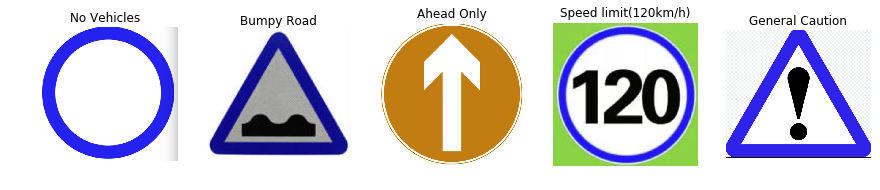

In [31]:
##total 5 new test images
n_new=5

#loaded 5 images I found from internet
img1=cv2.imread('traffic sign1.jpg')
img2=cv2.imread('traffic sign2.jpg')
img3=cv2.imread('traffic sign3.jpg')
img4=cv2.imread('traffic sign4.jpg')
img5=cv2.imread('traffic sign5.jpg')
images=[img1,img2,img3,img4,img5]
new_images=np.array(images)
labels=['No Vehicles','Bumpy Road', 'Ahead Only','Speed limit(120km/h)','General Caution']
test_true_labels=[15,22,35,8,25]
# define a function for plotting these 5 images with their true labels
def display_images_and_labels(images,labels):
    i=1
    plt.figure(figsize=(15, 5))
    for image in images:
        plt.subplot(1,5, i)  
        plt.axis('off')
        i += 1
        plt.imshow(image)
        plt.title(labels[i-2])
    plt.show()
        
        
display_images_and_labels(new_images,labels)



### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
When I predicted these 5 new images, I found some classes which have small size of example data could lower the overall accuracy. Besides different boundary shapes of each image under the same class (e.g.  I found even some traffics signs are under the same class, some of them which I found through internet are embedded in triangle shape  when compared with those image samples (in circle shape) from training set) and color variance also bothered predicting the correct result. Perhaps adding more data examples could be a better way of training my model to obtain a better test result. 

In [32]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [33]:
# each feature is normalized in range between 0.1 and 0.9
# _images=normalize_grayscale(new_images)
for image in new_images:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))



shape: (630, 678, 3), min: 26, max: 255
shape: (548, 618, 3), min: 0, max: 255
shape: (732, 748, 3), min: 17, max: 255
shape: (484, 488, 3), min: 0, max: 255
shape: (802, 902, 3), min: 0, max: 255


In [34]:
# Resize images
from scipy.misc import imresize
# from scipy.misc import imread
re_images = [imresize(image, (32, 32,3))for image in new_images]
re_images=np.array(re_images)
# re_images=re_images/255 -.5
for image in re_images:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))




shape: (32, 32, 3), min: 32, max: 255
shape: (32, 32, 3), min: 6, max: 255
shape: (32, 32, 3), min: 18, max: 255
shape: (32, 32, 3), min: 4, max: 255
shape: (32, 32, 3), min: 0, max: 255


## Model performance on test set

In [35]:
def y_predict_model(X_data, top_k=1):
    num_examples = len(X_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph('model_2.meta')

        saver.restore(sess,tf.train.latest_checkpoint('./'))
#         model_1.saver.restore(sess, os.path.join(DIR, "model_1"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(fc_layer3), k=top_k), 
                             feed_dict={features:X_data, keep_prob:1})
    return y_prob,y_pred

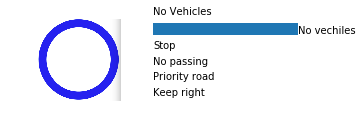

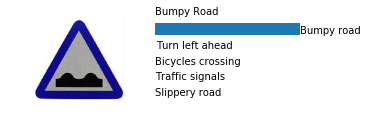

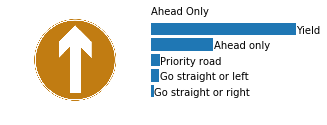

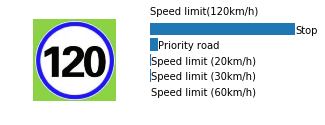

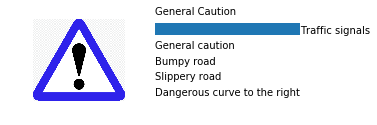

In [36]:
def visualize_top5(X_data):
    x_data_proc=np.zeros(X_data.shape)
    for i in range(n_new):
        x_data_proc[i]=preprocess_image(X_data[i])
    prob, pred=y_predict_model(x_data_proc, top_k=5)

    for i in range(n_new):
        plt.figure(figsize=(5, 1.5))
        gs=gridspec.GridSpec(1, 2, 	width_ratios=[2,3])
        plt.subplot(gs[0])
        plt.imshow(new_images[i])
        plt.axis('off')
        plt.subplot(gs[1])
        plt.barh(6-np.arange(n_new),prob[i], align='center')
        for i_label in range(5):
            plt.text(prob[i][i_label]+0.002, 6-i_label-.25,  \
                     sign_names.iloc[pred[i][i_label]]['SignName'])
        
        plt.axis('off');
        plt.text(0,6.95,labels[i]);
        plt.show();
            
visualize_top5(re_images)

In [37]:
# # preprocess data  :
# new_data_proc = np.zeros(re_images.shape)
# for i in range(n_new):
#     new_data_proc[i]=preprocess_image(re_images[i])
# #     new_data_proc[i] = contrast_norm(new_data[i])
    
# # make predictions
# _, y_pred = y_predict_model(new_data_proc)




In [43]:
# # show the prediction results
# fig, ax = plt.subplots(n_new,1, figsize=(10,10))
# for i in range(n_new) :
# #     img = plt.imread(re_images[i])
#     img=new_images[i]
#     ax[i].imshow(img)
#     ax[i].axis('off')
#     ax[i].set_title('Prediction: '+sign_names.iloc[y_pred[i][0]]['SignName'])

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
Unfortunately, my model performed badly with captured pictures. I am kind of worried about my model couldn't get a better accuracy back probably due to the underrepresented classes. Also I guess cutting off the boundary of each image and creating more data examples especially for those underrepresented classes would be a better way of making my model better, but the cNN architecture I applied in building my model seems to yield the best result of all methods.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
Only for the second picture, I got a correct prediction back, and the certainty of getting this correct label was higher than other four's.  Also, I found that although the first picture had the correct prediction which was fallen into one of last 4 but the certainty of getting the incorrect prediction which is label 13 in this case is pretty much higher than the certainty of getting the correct one(label 15). Besides, for the last three captured pictures, even my model got an incorrect prediction at first time, the true label wasn't fallen into any of last 4.  Based on my graph showed top k predictions for each image, the top one was always higher than any of last 4, and last 4 predictions distributed quite even, so it seems that my model was very certain of its incorrect prediction.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._



**Answer:**

-[Deep AMNIST FOR EXPERT]( https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html)

-[Tensorflow Tutorial on YOUTUBE](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

-[Traffic sign pictures selected from]( https://www.google.com/search?q=traffic+signs+pictures&biw=1410&bih=748&source=lnms&tbm=isch&sa=X&ved=0ahUKEwid--y0jqfQAhUhw1QKHccUBRQQ_AUIBigB)


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.